# Modelo creado por Marcelo Ortega
### Detección de alimentos en buen y mal estado

* Basándome en el modelo que trabajamos en clases, me llamó la atención cómo la red neuronal puede identificar patrones mínimos en los datos y relacionarlos para hacer predicciones.
Entonces me pregunté: ¿por qué no aplicar esto a la clasificación de alimentos en buen o mal estado?

* A partir de esta idea, comencé a recopilar imágenes de alimentos con manchas visibles o signos de descomposición y otros en buen estado, sin marcas. Así surgió la creación de este modelo, con el objetivo de que aprenda a distinguir alimentos frescos de los que están en mal estado.

### Importación de las dependencias

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms

* Línea que define una secuencia de transformaciones que se aplican a cada imagen antes de usarla en PyTorch (normalmente para entrenar una red neuronal).
1. transforms.Resize((128,128))
    * Cambia el tamaño de la imagen a 128x128 píxeles.
    * Útil porque las redes neuronales suelen requerir un tamaño fijo de entrada.
2. transforms.ToTensor()
    * Convierte la imagen de PIL (o NumPy) a un tensor de PyTorch.
    * Escala los valores de píxeles de 0–255 → 0–1 (float32).
    * Además, reorganiza los canales: de (H, W, C) → (C, H, W).
3. transforms.Normalize(mean, std)
    * Normaliza los valores de cada canal (R, G, B).
    * Con mean=(0.5,0.5,0.5) y std=(0.5,0.5,0.5):
    * Los valores que antes estaban en [0,1] pasan a [-1,1].
    * Esto es útil porque muchas redes (como CNNs) aprenden mejor con datos centrados en 0.

In [52]:
transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(), transforms.Normalize(mean =(0.5,0.5,0.5), std = (0.5,0.5,0.5))])

### Definiendo los sets de datos para el entrenamiento

In [53]:
set_train = datasets.ImageFolder(root ="./train", transform = transform)
set_test = datasets.ImageFolder(root ="./test", transform = transform)

### DataLoader en PyTorch

En PyTorch, el **DataLoader** es una herramienta que facilita el manejo de los datos durante el entrenamiento y la evaluación de un modelo. 
1.  batch_size: define la cantidad de muestras que se procesan en cada iteración.

* batch_size=6 en entrenamiento → el modelo recibe 6 imágenes por paso.

* batch_size=100 en prueba → se evalúan 100 imágenes a la vez (más eficiente porque no hay retropropagación).

2. shuffle=True: baraja los datos en cada época.
En entrenamiento es importante para que el modelo no aprenda patrones del orden.
En prueba no es estrictamente necesario, pero tampoco perjudica.

## En resumen:

    * train_loader → genera lotes de 6 imágenes barajadas para entrenar.

    * test_loader → genera lotes de 100 imágenes barajadas para evaluar.

In [54]:
from torch.utils.data import DataLoader

train_loader = DataLoader(set_train, batch_size=6, shuffle=True)
test_loader = DataLoader(set_test, batch_size=100, shuffle=True)

## Creación del modelo

In [55]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    self.net = nn.Sequential(
        nn.Linear(128 * 3 * 3, 512),
        nn.ReLU(),
        nn.Linear(512, 2)
    )

  def forward(self, x):
      x = self.conv(x)
      x = nn.AdaptiveAvgPool2d((3,3))(x)
      x = x.view(x.size(0), -1)
      x = self.net(x)
      return x

### Pasando el modelo a cuda
    * Decidís si vas a usar GPU o CPU.

    * Movés el modelo a ese dispositivo.

    * Elegís la función de pérdida.

    * Definís el optimizador que ajustará los pesos.

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Entrenando el modelo
     Este código recorre el dataset varias veces (épocas), entrena la red paso a paso usando forward → pérdida → backward → optimización, y guarda las métricas para cada época.
    Entrenamiento de la red y métricas
    * Pérdida (Loss): indica qué tan lejos está la predicción del modelo de la respuesta real.
    * Exactitud (Accuracy): porcentaje de predicciones correctas.
    * Forward pass: el modelo genera una predicción a partir de la entrada.
    * Backward pass: calcula cómo cada peso contribuyó al error.
    * Backpropagation: algoritmo completo que ajusta los pesos usando los gradientes para aprender.

### Flujo del entrenamiento:
    1. Forward → predicción.
    2. Calcular pérdida.
    3. Backward / Backpropagation → gradientes.
    4. Optimizer → actualizar pesos.
    5. Guardar métricas → pérdida y accuracy por época.

In [57]:
import matplotlib.pyplot as plt

epochs = 15

# Listas para guardar los valores de pérdida y accuracy por época
loss_list = []  # para guardar la pérdida promedio de cada época
acc_list = []   # para guardar la accuracy de cada época

for epoch in range(epochs):
    model.train()          # ponemos el modelo en modo entrenamiento
    total_loss = 0         # inicializamos la pérdida total de la época
    correct = 0            # inicializamos la cantidad de predicciones correctas
    total = 0              # inicializamos el total de ejemplos procesados

    for images, labels in train_loader:          # iteramos por cada batch del set de entrenamiento
        images, labels = images.to(device), labels.to(device)  # enviamos al dispositivo (CPU/GPU)

        optimizer.zero_grad()       # limpiamos los gradientes del paso anterior
        outputs = model(images)     # hacemos la predicción con el modelo
        loss = criterion(outputs, labels)  # calculamos la pérdida
        loss.backward()             # aplicamos la retropropagación
        optimizer.step()            # actualizamos los pesos con el optimizador

        total_loss += loss.item()   # acumulamos la pérdida total de la época

        _, predicted = torch.max(outputs.data, 1)  # obtenemos la clase predicha por la red
        total += labels.size(0)                   # acumulamos el total de ejemplos
        correct += (predicted == labels).sum().item()  # acumulamos la cantidad de predicciones correctas

    # calculamos el promedio de pérdida y la accuracy de la época
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total

    # guardamos los valores para graficar
    loss_list.append(avg_loss)
    acc_list.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/15, Loss: 0.6964, Accuracy: 44.44%
Epoch 2/15, Loss: 0.6888, Accuracy: 72.22%
Epoch 3/15, Loss: 0.6858, Accuracy: 55.56%
Epoch 4/15, Loss: 0.6793, Accuracy: 58.33%
Epoch 5/15, Loss: 0.6749, Accuracy: 63.89%
Epoch 6/15, Loss: 0.6667, Accuracy: 69.44%
Epoch 7/15, Loss: 0.6571, Accuracy: 66.67%
Epoch 8/15, Loss: 0.6389, Accuracy: 77.78%
Epoch 9/15, Loss: 0.6227, Accuracy: 80.56%
Epoch 10/15, Loss: 0.5988, Accuracy: 83.33%
Epoch 11/15, Loss: 0.5674, Accuracy: 80.56%
Epoch 12/15, Loss: 0.5544, Accuracy: 86.11%
Epoch 13/15, Loss: 0.5085, Accuracy: 80.56%
Epoch 14/15, Loss: 0.4873, Accuracy: 83.33%
Epoch 15/15, Loss: 0.4827, Accuracy: 80.56%


### Este bloque dibuja dos gráficos:
    1. Pérdida por época → indica si el modelo aprende correctamente.
    2. Exactitud por época → muestra la mejora en la predicción.
* Es útil para visualizar el entrenamiento y ver si el modelo está aprendiendo o si necesita ajustes.

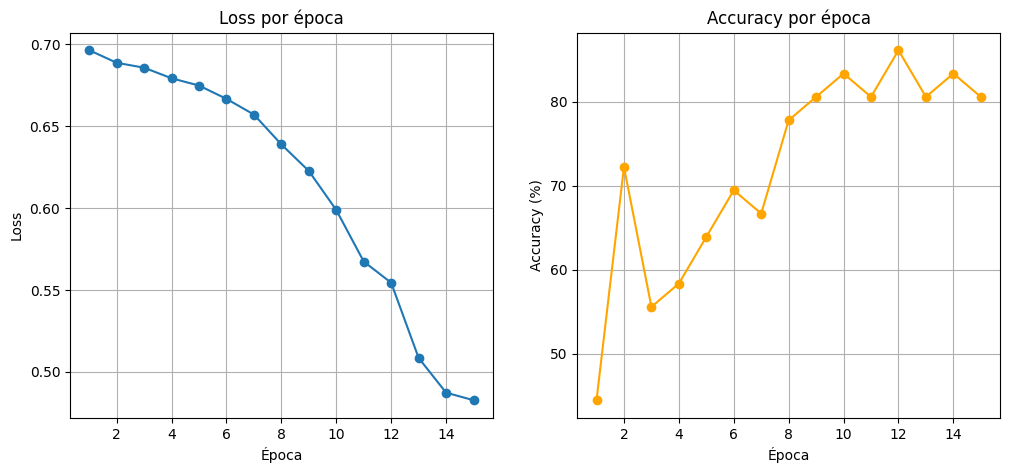

In [58]:
plt.figure(figsize=(12,5))  # definimos el tamaño de la figura

# Pérdida
plt.subplot(1,2,1)                     # primera gráfica (izquierda)
plt.plot(range(1, epochs+1), loss_list, marker='o')  # graficamos loss por época
plt.title('Loss por época')            # título de la gráfica
plt.xlabel('Época')                    # etiqueta eje X
plt.ylabel('Loss')                     # etiqueta eje Y
plt.grid(True)                         # mostramos cuadrícula

# Accuracy
plt.subplot(1,2,2)                     # segunda gráfica (derecha)
plt.plot(range(1, epochs+1), acc_list, marker='o', color='orange')  # graficamos accuracy
plt.title('Accuracy por época')        # título de la gráfica
plt.xlabel('Época')                    # etiqueta eje X
plt.ylabel('Accuracy (%)')             # etiqueta eje Y
plt.grid(True)                         # mostramos cuadrícula

plt.show()                             # mostramos la figura completa

# Probando el modelo con un alimento en buen estado

In [59]:
from PIL import Image

# Cargar la imagen
img = Image.open("./frutaLindaParaPrueba.png").convert("RGB")
transform = transforms.Compose(
    [
      transforms.Resize((128,128)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
  )

# Aplicar transform
img_tensor = transform(img)

# Agregar dimensión de batch
img_tensor = img_tensor.unsqueeze(0)  # shape: [1, 1, 28, 28]

# Pasar al device
img_tensor = img_tensor.to(device)

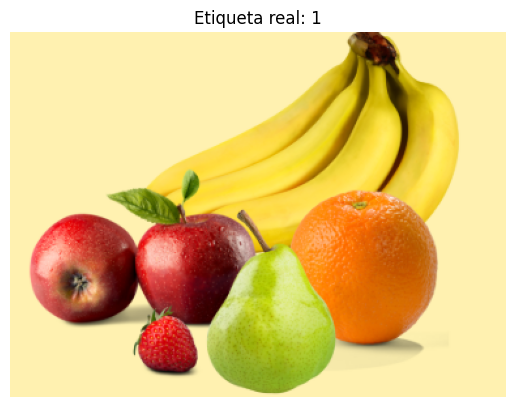

Se encuentra en buen estado
Accuracy en test: 80.56%


In [60]:

# Mostramos la imagen en una escala de grises
plt.imshow(img, cmap='gray')
plt.title(f'Etiqueta real: {1}')
plt.axis('off')
plt.show()

# ponemos el modelo en modo evaluacion
model.eval()
#hacemos la prediccion
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    if predicted.item() == 0:
        print("Se encuentra en buen estado")
    else: print("Se encuentra en mal estado")

accuracy_test = 100 * correct / total
print(f'Accuracy en test: {accuracy_test:.2f}%')

# Probando el modelo con un alimento en mal estado y viendo qué tal estuvo la exactitud de la predicción con la accurancy de la predicción

In [61]:
# Cargar la imagen
img2 = Image.open("./panPodridoParaPrueba.png").convert("RGB")
transform = transforms.Compose(
    [
      transforms.Resize((128,128)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
  )

# Aplicar transform
img_tensor = transform(img2)

# Agregar dimensión de batch
img_tensor = img_tensor.unsqueeze(0)  # shape: [1, 1, 28, 28]

# Pasar al device
img_tensor = img_tensor.to(device)

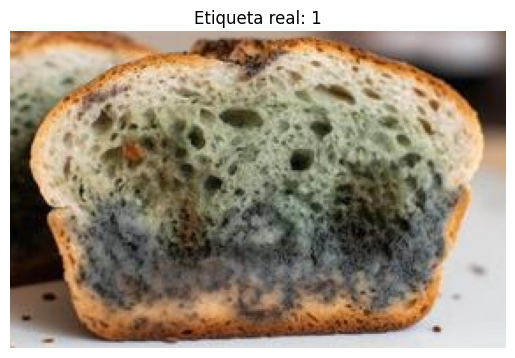

Se encuentra en mal estado
Accuracy en test: 80.56%


In [62]:
plt.imshow(img2, cmap='gray')
plt.title(f'Etiqueta real: {1}')
plt.axis('off')
plt.show()

# ponemos el modelo en modo evaluacion
model.eval()
#hacemos la prediccion
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    if predicted.item() == 0:
        print("Se encuentra en buen estado")
    else: print("Se encuentra en mal estado")

accuracy_test = 100 * correct / total
print(f'Accuracy en test: {accuracy_test:.2f}%')